In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skbio.diversity.alpha import gini_index, pielou_e
import os

In [2]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Functions

In [3]:
def greedy_power_mean_sample_final(data, k, p, pseudocount = 0.1):
    """Iteratively select rows from a matrix such that the selection criterion by
    column is maximized.

    Parameters
    ----------
    data : ndarray of shape (2D)
        Input data matrix (gene by species).
    k : int
        Number of rows (genes) to select.
    p : float or str
        Exponent of generalized mean, or special values: "min" or "max".
    pseudocount : float, optional
        Pseudocount to add to each cell value.
    min_universality_genes : int, optional
        Minimum universality threshold.

    Returns
    -------
    ndarray (1D)
        Row indices selected in order.

    """
    
    # numbers of genes (n) and species (m)
    n, m = data.shape

    # matrix is empty
    if n == 0 or m == 0:
        raise ValueError('Matrix is empty!')

    # matrix contains only zeroes
    if (data == 0).all():
        raise ValueError('Matrix only contains 0\'s')

    if k >= n:
        raise ValueError(f'k should be smaller than {n}')

    # Add pseudocount
    data = data + pseudocount

    # cumulative gene counts
    counts = np.zeros(m, dtype = int)

    # gene indices in original data matrix
    indices = np.arange(n)

    # indices of selected genes
    selected = []

    # iteratively select k genes
    for i in range(k):

        # calculate counts after adding each gene
        sums_ = counts + data

        # select a gene that maximizes the power mean gene count per species, using the cumulative matrix
        if isinstance(p, int) or isinstance(p, np.int64): 
            choice = pmean(sums_, int(p), axis = 1).argmax()
        elif p == 'min':
            choice = sums_.min(axis = 1).argmax()
        elif p == 'max':
            choice = sums_.max(axis = 1).argmax()
        else:
            raise ValueError(f'Invalid p: {p}.')

        # append index of selected gene
        selected.append(indices[choice])

        # update per-species gene counts
        counts = sums_[choice]

        # remove selected gene from data matrix
        data = np.delete(data, choice, axis = 0)

        # remove selected gene from indices
        indices = np.delete(indices, choice)

    # return np.sort(np.array(selected))
    return np.array(selected)

In [4]:
def greedy_power_mean_sample_mask(data, k, p, pseudocount = 0.1):
    """Iteratively select rows from a matrix such that the selection criterion by
    column is maximized.

    Parameters
    ----------
    data : ndarray of shape (2D)
        Input data matrix (gene by species).
    k : int
        Number of rows (genes) to select.
    p : float or str
        Exponent of generalized mean, or special values: "min" or "max".
    pseudocount : float, optional
        Pseudocount to add to each cell value.
    min_universality_genes : int, optional
        Minimum universality threshold.

    Returns
    -------
    ndarray (1D)
        Row indices selected in order.

    """
    
    # numbers of genes (n) and species (m)
    n, m = data.shape

    # matrix is empty
    if n == 0 or m == 0:
        raise ValueError('Matrix is empty!')

    # matrix contains only zeroes
    if (data == 0).all():
        raise ValueError('Matrix only contains 0\'s')

    if k >= n:
        raise ValueError(f'k should be smaller than {n}')

    # Add pseudocount
    data = data.astype(np.float64, copy = False) + pseudocount

    # cumulative gene counts
    counts = np.zeros(m, dtype = np.float64)

    # gene indices in original data matrix
    all_original_indices = np.arange(n)
    # Boolean mask to keep track of available genes
    available_row_mask = np.ones(n, dtype = bool)

    # indices of selected genes
    selected = np.empty(k, dtype = int)

    # iteratively select k genes
    for i in range(k):

        # Create new array containing only available rows
        current_data_slice = data[available_row_mask, :]
        # calculate counts after adding each gene
        sums_ = counts + current_data_slice

        # select a gene that maximizes the power mean gene count per species, using the cumulative matrix
        if isinstance(p, int) or isinstance(p, np.int64): 
            choice = pmean(sums_, int(p), axis = 1).argmax()
        elif p == 'min':
            choice = sums_.min(axis = 1).argmax()
        elif p == 'max':
            choice = sums_.max(axis = 1).argmax()
        else:
            raise ValueError(f'Invalid p: {p}.')

        # append index of selected gene
        original_indices_of_available_rows = all_original_indices[available_row_mask]
        chosen_original_idx = original_indices_of_available_rows[choice]
        selected[i] = chosen_original_idx

        # update per-species gene counts
        counts = sums_[choice, :]

        # Update mask
        available_row_mask[chosen_original_idx] = False

    # return np.sort(np.array(selected))
    return selected

In [5]:
def greedy_power_mean_sample_alt(data_orig, k, p, pseudocount = 0.1):
    """
    Select k rows from a matrix such that the selection criterion by column is maximized.
    This improved version avoids costly np.delete operations in a loop.

    Parameters
    ----------
    data_orig : ndarray (2D)
        Input data matrix.
    k : int
        Number of rows to select.
    p : float, int, or str
        Exponent for the power mean. Can be an integer, a float, or 'min'/'max'.
        If p=0, the geometric mean is used.
    pseudocount : float
        Value to add to all elements of the data matrix to ensure positivity
        for operations like log or negative/fractional powers.
    min_universality_genes : float or int
        A threshold used in a pre-check. If all rows in the original data
        sum to this specific value, an error is raised.

    Returns
    -------
    ndarray (1D)
        Row indices selected from the original matrix, in order of selection.
    """
    n, m = data_orig.shape

    # --- Input Validations ---
    if n == 0 or m == 0:
        raise ValueError('Matrix is empty!')

    # Check on original data before pseudocount
    if np.all(data_orig == 0):
        raise ValueError("Matrix only contains 0's (before pseudocount).")

    if not isinstance(k, int) or k <= 0:
        raise ValueError(f'k must be a positive integer, got {k}.')
    if k >= n:
        raise ValueError(f'k ({k}) must be smaller than the number of rows ({n}).')

    # --- Data Preparation ---
    # Work on a copy, ensure float type for calculations, and add pseudocount.
    # Using float64 for precision with powers and sums.
    data = data_orig.astype(np.float64)
    data += pseudocount

    # --- Initialization for Selection Process ---
    # Stores the cumulative sum of features for the currently selected set of rows.
    current_cumulative_sum = np.zeros(m, dtype=np.float64)

    # Array to store the indices of the selected rows.
    selected_indices = np.empty(k, dtype = int)
    # Boolean mask to keep track of rows that have already been selected.
    is_row_selected_mask = np.zeros(n, dtype=bool)

    # --- Iterative Selection ---
    for i in range(k):
        best_score_for_this_iteration = -np.inf
        best_row_idx_for_this_iteration = -1
        # To store the sum vector corresponding to the best choice, avoiding re-computation.
        best_potential_sum_if_selected = None

        # Iterate through all original rows to find the next best one.
        for current_row_idx in range(n):
            if is_row_selected_mask[current_row_idx]:
                continue  # Skip if this row has already been selected.

            # Calculate the potential new cumulative sum if this row were added.
            potential_new_sum = current_cumulative_sum + data[current_row_idx, :]
            
            current_score = 0.0
            # Determine the type of p and calculate score accordingly.
            use_numeric_p = False

            if isinstance(p, int) or isinstance(p, np.int64): 
                current_score = pmean(potential_new_sum, int(p))
            elif p == 'min':
                current_score = potential_new_sum.min(axis = 1)
            elif p == 'max':
                current_score = potential_new_sum.max(axis = 1)
            else:
                raise ValueError(f'Invalid p: {p}.')

            if current_score > best_score_for_this_iteration:
                best_score_for_this_iteration = current_score
                best_row_idx_for_this_iteration = current_row_idx
                best_potential_sum_if_selected = potential_new_sum

        # Record the selected row and update states.
        selected_indices[i] = best_row_idx_for_this_iteration
        is_row_selected_mask[best_row_idx_for_this_iteration] = True
        current_cumulative_sum = best_potential_sum_if_selected # Use the stored sum

    return selected_indices

Load WoL2 data

In [6]:
df = pd.read_table(f'assembly.tsv', sep = '\t', index_col = 0)
# Get only complete genomes
# df = df.loc[df.query('assembly_level == "Complete Genome" or assembly_level == "Chromosome"').index]
df.shape

(15953, 22)

In [7]:
levels = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
taxonomy = pd.read_csv(f'lineages_gtdb_wol2.txt', index_col = 0, 
                     sep = r'\t|;', engine = 'python', header = None,
                    names = levels)
taxonomy = taxonomy.map(lambda x: x.strip())
# taxonomy = taxonomy.loc[df.index]
# Remove taxa with no taxonomic information, i.e. p__
taxonomy = taxonomy[taxonomy['phylum'] != 'p__']
taxonomy.shape

(15656, 7)

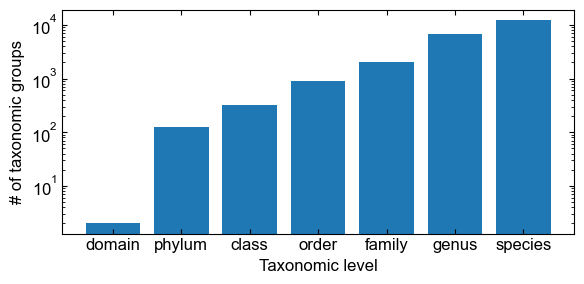

In [8]:
plt.figure(figsize = (6, 3))
data = []
for level in levels:
    data.append(len(taxonomy[level].value_counts()))
plt.bar(range(len(levels)), [x for x in data], tick_label = levels)
plt.yscale('log')
plt.ylabel('# of taxonomic groups')
plt.xlabel('Taxonomic level')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.show()

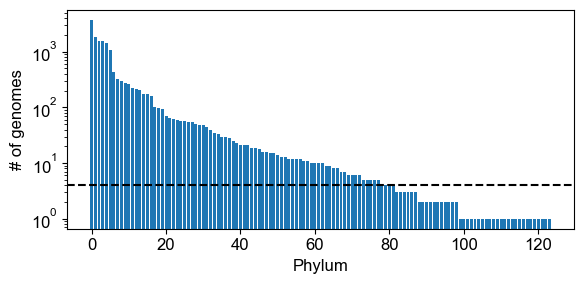

In [9]:
plt.figure(figsize = (6, 3))
y = taxonomy['phylum'].value_counts()
x = np.arange(len(y))
plt.bar(x, y)
plt.axhline(y = 4, ls = 'dashed', color = 'k')
# plt.axvline(x = 10, ls = 'dashed', color = 'k')
plt.yscale('log')
# plt.xticks([])
plt.xlabel('Phylum')
plt.ylabel('# of genomes')
plt.show()

In [12]:
y[y > 4]

phylum
p__Proteobacteria        3712
p__Patescibacteria       1872
p__Actinobacteriota      1555
p__Firmicutes            1553
p__Bacteroidota          1460
                         ... 
p__Caldisericota            5
p__Hadarchaeota             5
p__Ratteibacteria           5
p__KSB1                     5
p__Desulfobacterota_C       5
Name: count, Length: 78, dtype: int64

# Testing taxonomic imbalance

If computational resources were unlimited, we can test taxonomic imbalance with the following protocol:

1. Iterate over from 2 to T, where T is the maximum # of taxonomic groups at a given taxonomic level (e.g. phylum).
2. Select $\hat{T}$ groups randomly.
3. Randomly select genomes across groups with abundances following a $\beta$ distribution.

However, doing this grid search is computationally expensive. Therefore, let us fix some paramaters to ease the computational burden.

1. Set a maximum number of taxonomic groups to T = 17 at the phylum level (same as WoL2 analized in manuscript).
2. Fix the maximum number of genomes to 500.
3. Sampled the abundance of genomes across T taxonomic groups following a $\beta$ distribution. The parameters of the distribution are tested before hand so the unevenness is high (measured with Gini index, as suggested in [Martinez-Gutierrez, 2021](https://academic.oup.com/mbe/article/38/12/5514/6358142?login=true): 0 --> evenness; 1 --> unevenness).
4. For each abundance, randomly sample a taxonomic group and sample genomes within.
5. Repeat steps 4 and 5 for 10 replicates.


In [10]:
# Parameters
T = 17 # Number of taxonomic groups, same as the WoL2 dataset tested on manuscript
num_genomes = 500 # Number of genomes across taxonomic groups
k = 400 # Number of marker genes to select 
p = 0 # Exponent p for selection
replicates = np.arange(10) # Number of replicates
taxonomic_level = 'phylum' # Taxonomic level to use for selection
min_num_genomes = 4 # Minimum number of genomes per taxonomic group

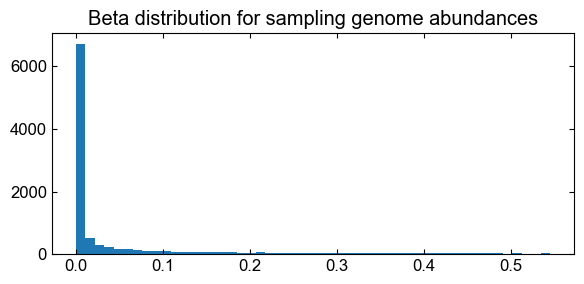

In [11]:
plt.figure(figsize = (6, 3))
rng = np.random.default_rng(42)
x = rng.beta(a = 0.1, b = 1, size = 10000)
plt.hist((x / x.sum()) * num_genomes, bins = 50)
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.title('Beta distribution for sampling genome abundances')
plt.show()

In [12]:
ginis = np.empty(len(replicates), dtype = float)
pielous = np.empty(len(replicates), dtype = float)
selected_taxonomic_groups = {}

In [13]:
for rep in replicates:
    # Initialize dict
    selected_taxonomic_groups[rep] = {}
    # Fix seed
    rng = np.random.default_rng(rep)
    # Sample abundance
    abundance = rng.beta(a = 0.1, b = 1, size = T)
    relative_abundance = abundance / abundance.sum()
    abundance_genomes = np.round(relative_abundance * num_genomes).astype(int)
    # # If abundance is 0 set it to 1
    # abundance_genomes[abundance_genomes == 0] = 1
    # Or reescale abundance so the minimum is min_num_genomes
    abundance_genomes = abundance_genomes + min_num_genomes
    # Calculate gini index as a measure of evenness
    ginis[rep] = gini_index(abundance_genomes)
    pielous[rep] = pielou_e(abundance_genomes)
    # Get taxonomic groups
    taxonomic_groups = taxonomy[taxonomic_level].unique()
    # Randomly select a group and sample genomes according to abundance
    for i, num_genomes_sample in enumerate(abundance_genomes):
        # rng2 = np.random.default_rng(i)
        taxonomic_group = rng.choice(taxonomic_groups)
        genomes = taxonomy[taxonomy[taxonomic_level] == taxonomic_group].index
        # Check if taxonomic group has enough genomes. If not keep sampling...
        if len(genomes) < num_genomes_sample:
            # Sample a different taxonomic group
            while len(genomes) < num_genomes_sample:
                taxonomic_group = rng.choice(taxonomic_groups)
                genomes = taxonomy[taxonomy[taxonomic_level] == taxonomic_group].index
        # Add genomes and taxonomic group
        selected_taxonomic_groups[rep][taxonomic_group] = rng.choice(genomes, size = num_genomes_sample, replace = False)
        # Remove taxonomic group from the list of taxonomic groups
        taxonomic_groups = taxonomic_groups[taxonomic_groups != taxonomic_group]
        
print(f'Mean gini index: {ginis.mean():.3f} +/- {ginis.std():.3f}')
# print(f'Mean pielou evenness: {pielous.mean():.3f} +/- {pielous.std():.3f}')

Mean gini index: 0.656 +/- 0.043


In [14]:
for rep in replicates:
    print(f'Replicate: {rep}, Gini index: {ginis[rep]:.3f}')
    for tax, genomes in selected_taxonomic_groups[rep].items():
        print(f'\t{tax} with {len(genomes)} genomes: {genomes[:3]}')

Replicate: 0, Gini index: 0.640
	p__Fusobacteriota with 12 genomes: ['G000158315' 'G010367435' 'G000691745']
	p__Marinisomatota with 4 genomes: ['G001626675' 'G001577025' 'G004402895']
	p__Firmicutes_G with 6 genomes: ['G001513395' 'G900019985' 'G007116995']
	p__Deferribacterota with 4 genomes: ['G001603805' 'G000010985' 'G000421105']
	p__Thermoproteota with 197 genomes: ['G001515905' 'G001316145' 'G000223395']
	p__Thermoplasmatota with 175 genomes: ['G000383395' 'G001512965' 'G003663595']
	p__Proteobacteria with 43 genomes: ['G002172695' 'G001695855' 'G000482725']
	p__Patescibacteria with 63 genomes: ['G001001645' 'G002791975' 'G002869265']
	p__Calescibacterota with 4 genomes: ['G011373475' 'G000494225' 'G000404605']
	p__Fibrobacterota with 4 genomes: ['G001462245' 'G900142475' 'G900143015']
	p__Firmicutes_B with 9 genomes: ['G011048115' 'G900101835' 'G000190635']
	p__Halobacteriota with 8 genomes: ['G000337455' 'G003164755' 'G000970045']
	p__Planctomycetota with 11 genomes: ['G011369

## For reference, the Gini index for the 1,510 genomes of the WoL2 is...

In [15]:
genomes_wol2_tmarsel = np.loadtxt(f'genomes_sampled_family_10.txt', dtype = str)
genomes_wol2_tmarsel.shape

(1510,)

In [16]:
abundance_wol2 = taxonomy.loc[genomes_wol2_tmarsel]['phylum'].value_counts()
abundance_wol2

phylum
p__Proteobacteria         627
p__Actinobacteriota       262
p__Firmicutes             189
p__Bacteroidota            91
p__Firmicutes_A            47
p__Cyanobacteria           40
p__Chlamydiota             39
p__Halobacteriota          34
p__Methanobacteriota_B     30
p__Thermoproteota          28
p__Campylobacterota        26
p__Chloroflexota           22
p__Desulfobacterota_I      18
p__Spirochaetota           18
p__Methanobacteriota       16
p__Planctomycetota         12
p__Deinococcota            11
Name: count, dtype: int64

In [17]:
gini_index(abundance_wol2.values)

0.5865212310089598

Therefore, the taxonomic imbalanced datasets are more uneven than the WoL2 dataset tested on the manuscript.

## For reference, the Gini index for the 1,510 genomes of the EMP is...??

If curious on why these mags were excluded, check `AugmentingPhyloSignalMicrobes/markers_selection
/marker_selection_emp.ipynb` notebook.

In [18]:
mags_excluded = ['SaltMarsh.Metabat.Bin.73', 'SaltMarsh.Metabat.Bin.70', 'SaltMarsh.Metabat.Bin.9', 'SaltMarsh.Metabat.Bin.33',
'Steppe.Metabat.Bin.3', 'Mayer_watershed.Metabat.Bin.5', 'Jensen_Benthic.Metabat.Bin.3', 'Jensen_Benthic.Metabat.Bin.5', 'Lichen.Metabat.Bin.11',
'Lichen.Metabat.Bin.19', 'Lichen.Metabat.Bin.29', 'Seedorf_soil.Metabat.Bin.1', 'Seedorf_soil.Metabat.Bin.2', 'Seedorf_soil.Metabat.Bin.6',
'Marsh.Metabat.Bin.10', 'Marsh.Metabat.Bin.12', 'Marsh.Metabat.Bin.35', 'Marsh.Metabat.Bin.7']

In [19]:
mags = np.loadtxt('bins.txt', dtype = str)
mags = mags[~np.isin(mags, mags_excluded)]
mags.shape

(793,)

In [20]:
emp_taxonomy = pd.read_csv(f'lineages_gtdbtk_emp.txt', index_col = 0, 
                     sep = r'\t|;', engine = 'python', header = None,
                    names = levels)
emp_taxonomy.map(lambda x: x.strip() if x is not None else x)
emp_taxonomy = emp_taxonomy.loc[mags]
# Remove phyla with 'p__' or None
emp_taxonomy = emp_taxonomy[emp_taxonomy['phylum'] != 'p__']
emp_taxonomy = emp_taxonomy[emp_taxonomy['phylum'].notna()]
emp_taxonomy.shape

(757, 7)

In [21]:
abundance_emp = emp_taxonomy['phylum'].value_counts()
abundance_emp

phylum
 p__Pseudomonadota        169
 p__Bacteroidota          159
 p__Bacillota_A           158
 p__Actinomycetota         34
 p__Acidobacteriota        24
 p__Spirochaetota          23
 p__Bacillota_I            23
 p__Chloroflexota          22
 p__Bacillota              21
 p__Verrucomicrobiota      21
 p__Planctomycetota        19
 p__Patescibacteria        11
 p__Desulfobacterota       11
 p__Gemmatimonadota         8
 p__Myxococcota             5
 p__Bacillota_C             4
 p__Cyanobacteriota         4
 p__Desulfobacterota_B      4
 p__CSP1-3                  4
 p__Campylobacterota        3
 p__Halobacteriota          3
 p__Nitrospirota            3
 p__Fibrobacterota          3
 p__Desulfobacterota_D      3
 p__Chlamydiota             2
 p__Eremiobacterota         2
 p__Armatimonadota          2
 p__Bacillota_B             2
 p__Hydrogenedentota        1
 p__Dependentiae            1
 p__Thermotogota            1
 p__Fusobacteriota          1
 p__SAR324                  1
 p_

In [22]:
gini_index(abundance_emp.values)

0.7275255509977057

### Therefore, the taxonomic imbalanced datasets are not as uneven than the EMP dataset tested on the manuscript, but much more uneven than WoL2.

Save data

In [23]:
dataPathOut = f'./out'

In [24]:
np.savetxt(f'{dataPathOut}/gini_index.txt', ginis)

In [25]:
for rep in replicates:
    # Create output directory
    os.makedirs(f'{dataPathOut}/replicate_{rep}/genomes', exist_ok = True)
    os.makedirs(f'{dataPathOut}/replicate_{rep}/markers', exist_ok = True)
    os.makedirs(f'{dataPathOut}/replicate_{rep}/pipeline', exist_ok = True)
    os.makedirs(f'{dataPathOut}/replicate_{rep}/orfs', exist_ok = True)
    with open(f'{dataPathOut}/replicate_{rep}/genomes/genomes.txt', 'w') as f:
        for tax, genomes in selected_taxonomic_groups[rep].items():
            # f.write(f'{tax}:{",".join(genomes)}\n')
            for genome in genomes:
                f.write(f'{genome}\n')